In [9]:
import tribo as tb
import numpy as np
import os 
import re
import pandas as pd

from tribo import Tribo_file

outlier_tests = {'OA_Project_Tests_CoF':['20wt_C20A2wtOA_10N_100mms_Test11', \
                       '20wt_C20A_20N_100mms_Test2', \
                        '20wt_C20A_20N_20mms_Test8', \
                        '20wt_C20A2wtOA_20N_20mms_Test7', \
						'100-TOCN_10N_20mms_Test7', \
						'100-TOCN_20N_20mms_Test10'], \
            
            'PAO_IL_ZDDP_CoF': ['0_OA0_20N_100mms_test2', \
                                '1_IL_20N_100mms_Test5', \
                                '1_IL_20N_20mms_Test2', \
                                '1_IL_20N_20mms_Test1']}

folder = 'OA_Project_Tests_CoF'

files_in_folder = os.listdir(folder)
print(f" Found {len(files_in_folder)} files in {folder}")


Tribo_files_list, complete_CoF_2 = tb.load_files(files_in_folder,folder,outlier_tests=outlier_tests)
sg_smoothing_array=tb.smoothing_df(complete_CoF_2)
speeds_list, names_list = tb.get_speeds_and_names_in_folder(files_in_folder,Tribo_files_list)

rows=tb.remove_outliers(Tribo_files_list)
df = pd.DataFrame(rows,columns=['Name','CoF_avg','CoF_std','Speed','Percent','Force','Test'])
speed_sheets_list=tb.sort_dfs_by_speed(speeds_list,df)


tb.export_excel_results(speed_sheets_list,speeds_list,sg_smoothing_array,folder,complete_CoF_2,verbose=True)			

 Found 46 files in OA_Project_Tests_CoF
speed sheet
          Name   CoF_avg   CoF_std   Speed Percent Force       Test
0        TOCN  0.142016  0.017119  100mms     100   10N     Test11
1        TOCN  0.140715  0.014537  100mms     100   10N     Test12
2        TOCN  0.133261  0.014170  100mms     100   10N      Test4
5        TOCN  0.141316  0.009408  100mms     100   20N      test1
6        TOCN  0.126412  0.007036  100mms     100   20N     Test13
7        TOCN  0.136243  0.010152  100mms     100   20N     Test14
10  C20A2wtOA  0.129528  0.012955  100mms    20wt   10N     Test12
11  C20A2wtOA  0.123207  0.015736  100mms    20wt   10N  Test15new
12  C20A2wtOA  0.119926  0.012541  100mms    20wt   10N  Test16new
13  C20A2wtOA  0.125577  0.012493  100mms    20wt   10N      Test4
18  C20A2wtOA  0.126669  0.007815  100mms    20wt   20N     Test13
19  C20A2wtOA  0.193564  0.029036  100mms    20wt   20N     Test14
20  C20A2wtOA  0.164720  0.030756  100mms    20wt   20N  Test17new
21  C20A2

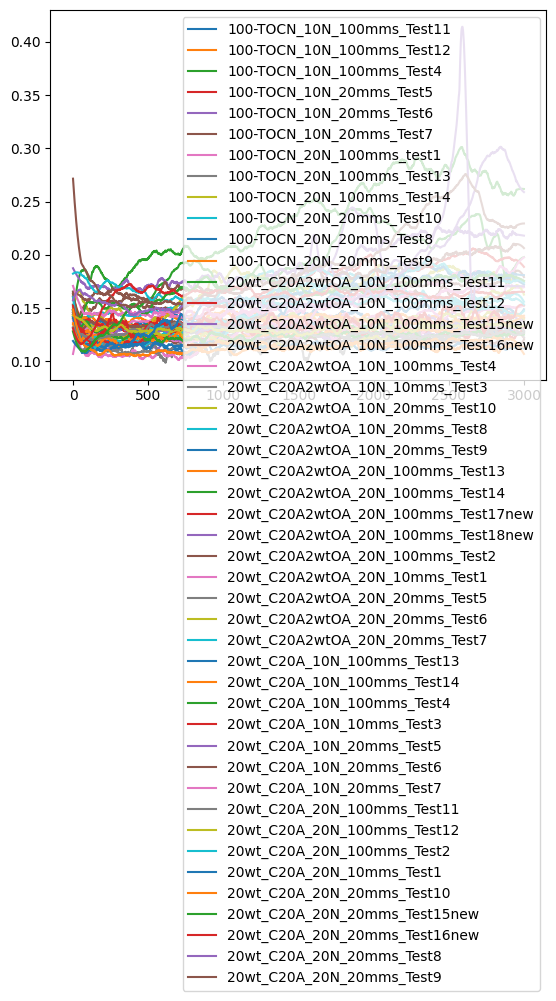

In [10]:
tb.cof_overlays(sg_smoothing_array)



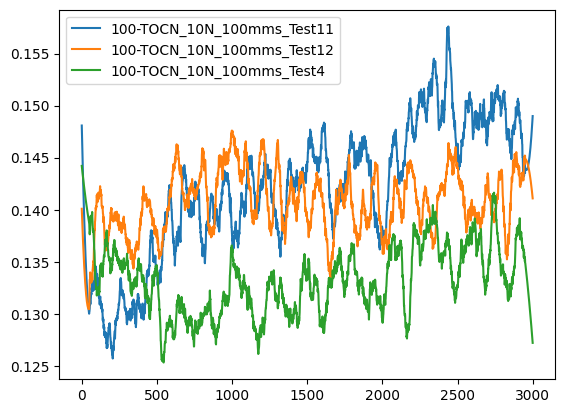

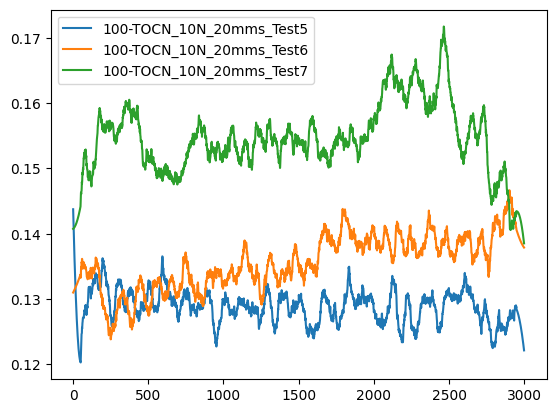

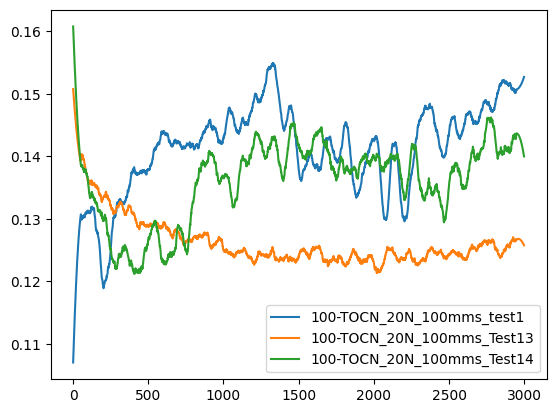

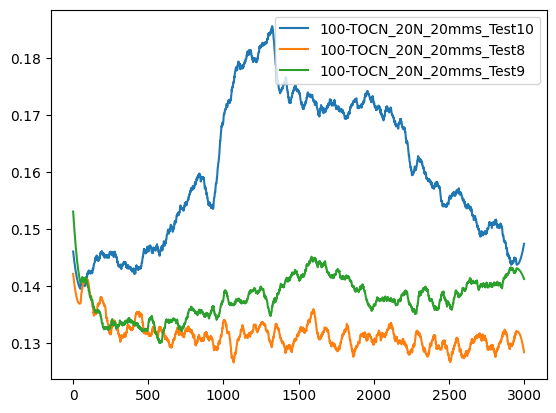

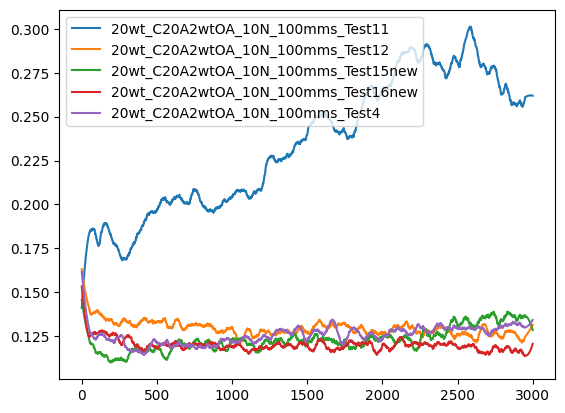

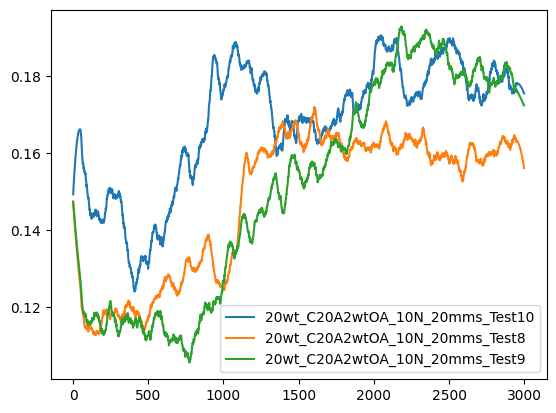

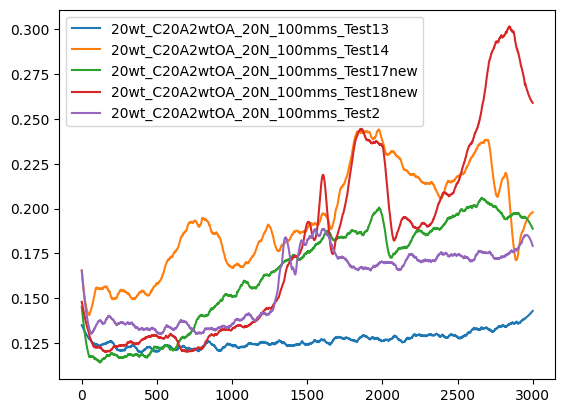

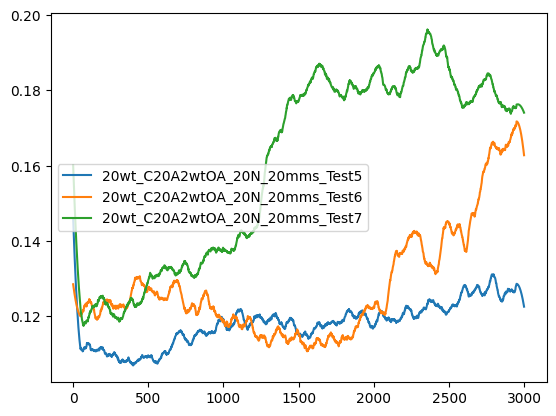

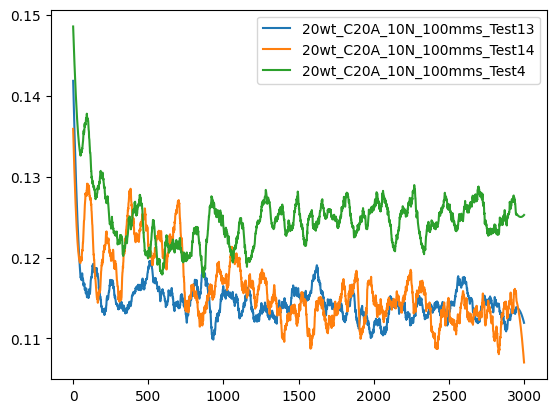

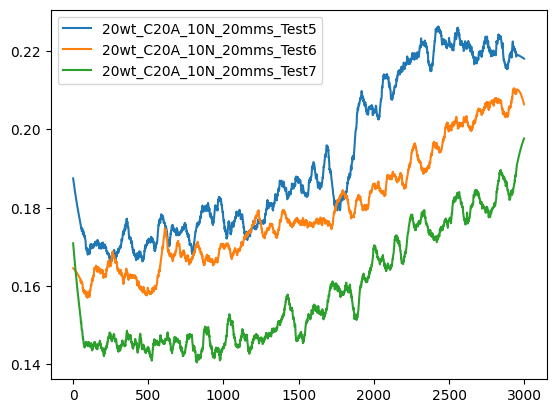

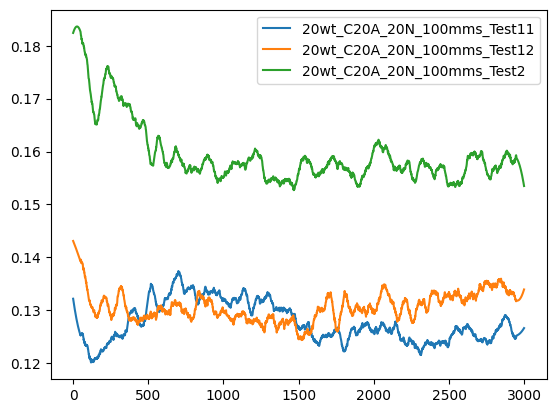

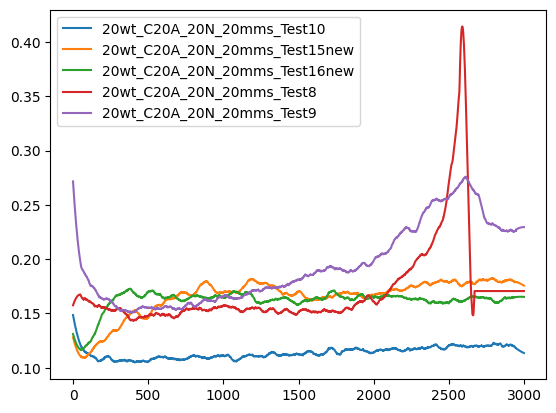

In [11]:
#-----------------------------------------------------------------------
# The following is a Python Dictionary of the specific tests that were chosen to be used in the Average CoF Bar Graphs
avg_CoF_tests = {'OA_Project_Tests_CoF':['100-TOCN_20N_20mms_Test8', \
                                         '20wt_C20A_10N_20mms_Test6', \
                                         '20wt_C20A_10N_100mms_Test14', \
                                         '20wt_C20A_20N_20mms_Test16new', \
                                         '20wt_C20A_20N_100mms_Test12', \
                                        '20wt_C20A2wtOA_10N_20mms_Test8', \
                                        '20wt_C20A2wtOA_10N_100mms_Test4', \
                                        '20wt_C20A2wtOA_20N_20mms_Test6', \
                                        '20wt_C20A2wtOA_20N_100mms_Test17new', \
                                        '100-TOCN_10N_100mms_Test12', \
                                        '100-TOCN_10N_20mms_Test6', \
                                        '100-TOCN_20N_100mms_Test14'], \
                                        
                 'PAO_IL_ZDDP_CoF': ['0_OA0_20N_100mms_test13', \
                                     '0_OA0_20N_20mms_test1', \
                                     '1-ZADP_20N_100mms_Test5', \
                                     '1-ZADP_20N_20mms_Test3', \
                                     '1_IL_20N_100mms_Test5', \
                                     '1_IL_20N_20mms_Test4']}                      

#-----------------------------------------------------------------------

tb.plot_combinations_of_params(sg_smoothing_array, folder)

# for column in sg_smoothing.columns:
#     if '20N' in column:
#         if re.sub(pattern, '', column) in unique_names:
            
#             plt.plot(sg_smoothing[column],label=column)
#             plt.legend()

In [12]:
tb.output_good_tests(avg_CoF_tests, folder, sg_smoothing_array)

# # with pd.ExcelWriter(f'{folder}.xlsx') as writer:
#     # print(sg_smoothing.head())
# print(avg_CoF_tests[folder], f'\n Length: {len(avg_CoF_tests[folder])}')
# count = 0
# good_test_in_folder_list = []
# for ii in range(len(sg_smoothing_array.columns)):
#     for jj in range(len(avg_CoF_tests[folder])):
#         # print(  avg_CoF_tests[folder][jj]==sg_smoothing.columns[ii])
#         if  avg_CoF_tests[folder][jj]==sg_smoothing_array.columns[ii]:
#             count += 1
#             print(avg_CoF_tests[folder][jj])
#             good_test_in_folder_list.append(avg_CoF_tests[folder][jj])
# print(count)

# good_test_df = sg_smoothing_array.loc[:, good_test_in_folder_list]

# # for good_test in avg_CoF_tests[folder]:
# #     good_test_df = pd.concat([good_test_df, sg_smoothing[good_test]], ignore_index=True)
# print(good_test_df)

# with pd.ExcelWriter(f'{folder}.xlsx', engine='openpyxl', mode='a') as writer: 
#     good_test_df.to_excel(writer, sheet_name='Good_Tests', index=False)
#     # good_test_df.to_excel(writer, sheet_name='Good Tests', index=False)


['100-TOCN_20N_20mms_Test8', '20wt_C20A_10N_20mms_Test6', '20wt_C20A_10N_100mms_Test14', '20wt_C20A_20N_20mms_Test16new', '20wt_C20A_20N_100mms_Test12', '20wt_C20A2wtOA_10N_20mms_Test8', '20wt_C20A2wtOA_10N_100mms_Test4', '20wt_C20A2wtOA_20N_20mms_Test6', '20wt_C20A2wtOA_20N_100mms_Test17new', '100-TOCN_10N_100mms_Test12', '100-TOCN_10N_20mms_Test6', '100-TOCN_20N_100mms_Test14'] 
 Length: 12
100-TOCN_10N_100mms_Test12
100-TOCN_10N_20mms_Test6
100-TOCN_20N_100mms_Test14
100-TOCN_20N_20mms_Test8
20wt_C20A2wtOA_10N_100mms_Test4
20wt_C20A2wtOA_10N_20mms_Test8
20wt_C20A2wtOA_20N_100mms_Test17new
20wt_C20A2wtOA_20N_20mms_Test6
20wt_C20A_10N_100mms_Test14
20wt_C20A_10N_20mms_Test6
20wt_C20A_20N_100mms_Test12
20wt_C20A_20N_20mms_Test16new
12
      100-TOCN_10N_100mms_Test12  100-TOCN_10N_20mms_Test6  \
0                       0.140088                  0.131004   
1                       0.139682                  0.131049   
2                       0.139285                  0.131095   
3      

In [14]:
tb.frict_table_maker(folder)


This block of code will reorganize the "total" sheet into a friction table based on the user input which will 
include percent reduction for ease of integration into origin.


The friction tables have been successfully saved to OA_Project_Tests_CoF.xlsx.
